In [ ]:
!pip install scipy

In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib.request
import os
import zipfile
import random
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile


In [ ]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "/MyProjects/data/catsdogs.zip"
download_dir = '/MyProjects/data/'

urllib.request.urlretrieve(data_url, data_file_name)

In [ ]:
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [ ]:
print("Number of cat images:",len(os.listdir('/MyProjects/data/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/MyProjects/data/PetImages/Dog/')))

In [ ]:
try:
    os.mkdir('/MyProjects/data/cats-v-dogs')
    os.mkdir('/MyProjects/data/cats-v-dogs/training')
    os.mkdir('/MyProjects/data/cats-v-dogs/testing')
    os.mkdir('/MyProjects/data/cats-v-dogs/training/cats')
    os.mkdir('/MyProjects/data/cats-v-dogs/training/dogs')
    os.mkdir('/MyProjects/data/cats-v-dogs/testing/cats')
    os.mkdir('/MyProjects/data/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/MyProjects/data/PetImages/Cat/"
TRAINING_CATS_DIR = "/MyProjects/data/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/MyProjects/data/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/MyProjects/data/PetImages/Dog/"
TRAINING_DOGS_DIR = "/MyProjects/data/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/MyProjects/data/cats-v-dogs/testing/dogs/"

split_size = .9
#split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
#split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [9]:
print("Number of training cat images", len(os.listdir('/MyProjects/data/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/MyProjects/data/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/MyProjects/data/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/MyProjects/data/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


In [10]:
TRAINING_DIR = "/MyProjects/data/cats-v-dogs/training/"
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/MyProjects/data/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [5]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "/MyProjects/weights/inception_v3.h5"
#urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [11]:
with tf.device("gpu:0"):
    # compile the model
    model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

    # train the model (adjust the number of epochs from 1 to improve performance)
    history = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=2,
                batch_size = 64,
                verbose=1)

Epoch 1/2
190/225 [========================>.....] - ETA: 1:08 - loss: 0.2474 - acc: 0.9063

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 485s 2s/step - loss: 0.2352 - acc: 0.9099 - val_loss: 0.0830 - val_acc: 0.9684
Epoch 2/2
225/225 [==============================] - 436s 2s/step - loss: 0.1519 - acc: 0.9380 - val_loss: 0.1054 - val_acc: 0.9612


<Figure size 640x480 with 0 Axes>

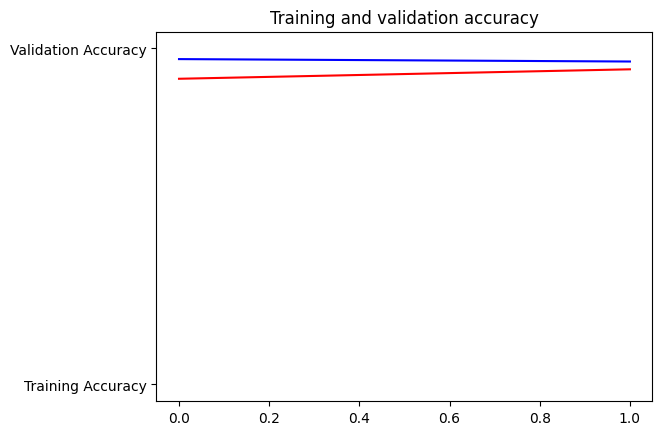

<Figure size 640x480 with 0 Axes>

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



In [19]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

## This is just for test
test_dir = '/MyProjects/data/cats-v-dogs/final_testing/'
path = test_dir + '1.jpg'
img = load_img(path, target_size=(150, 150))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)
print(classes[0])
if classes[0]>0.5:
    print(path + " is a dog")
else:
    print(path + " is a cat")


1/1 [==============================] - 1s 827ms/step
[[1.]]
[1.]
/MyProjects/data/cats-v-dogs/final_testing/1.jpg is a dog
